### Exploring the annotated data.

In [1]:
from datasets import load_dataset, disable_caching
import pandas as pd

# can infer the generic loader script this easily
disable_caching()
# cache location [click](%userprofile%/.cache/huggingface/datasets)
# needs force_redownload to avoid loading incorrect cached stuff
ds = load_dataset("json", data_dir="./data/annotated/", download_mode="force_redownload", cache_dir=None)
# ds = load_dataset("json", data_dir="./data/annotated_test/", download_mode="force_redownload", cache_dir=None)
df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
        num_rows: 19622
    })
})

In [2]:
# fewer than 6k unique authors in shaders20k
df["author"].nunique()

5924

In [3]:
#redo the df

df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
#

In [4]:
df["test"].value_counts().head(10)

test
ok          11324
error        5014
timeout      3260
timedout       24
Name: count, dtype: int64

In [5]:
# list of permissive licenses like: https://huggingface.co/datasets/bigcode/the-stack-v2/blob/main/license_stats.csv (gated?)
# maybe this instead: https://huggingface.co/datasets/bigcode/the-stack/blob/main/licenses.json
# seems to be the one they actually use: https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt 

import requests
permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
permissive_list = [l.lower() for l in permissive_list]

print(len(permissive_list))

824


In [6]:

print(ds["train"].unique("license"))
# filter permissive licenses
filtered_ds = ds["train"].filter(lambda x: x["license"] in permissive_list + ["CC-BY-NC-SA-3.0"]) # permissive or base case(not actually permissive...) what about those AND and OR classifications?
filtered_ds = filtered_ds.filter(lambda x: x["test"] == "ok") # ok means it actually runs, valid was just that naga didn't error... but this also has issues
filtered_ds = filtered_ds.filter(lambda x: x["published"] == "Public API") # naga is the author of the test cases
filtered_ds

['CC-BY-NC-SA-3.0', 'cc-by-nc-sa-3.0', 'bsd-new', 'mit', 'cc-by-4.0', 'proprietary-license', 'cc-by-nc-nd-3.0', 'bsd-simplified', 'cc0-1.0', 'unknown-license-reference', 'public-domain', 'apache-2.0', 'cc-by-nc-sa-4.0', 'agpl-3.0', 'cc-by-sa-3.0', 'cc-by-3.0', 'cc-by-sa-2.5', 'cc-by-sa-4.0', 'cc-by-sa-4.0 WITH generic-exception', 'cc-by-3.0 AND mit', 'cc-by-nc-sa-2.0', 'cc-by-nc-sa-3.0 AND proprietary-license', 'wtfpl-2.0', 'gpl-3.0', 'cc-by-4.0 OR cc-by-3.0', 'beerware', 'gpl-3.0-plus OR cc-by-sa-3.0', 'unlicense', 'cc-by-nc-nd-4.0', 'warranty-disclaimer', 'x11', 'gpl-3.0-plus', 'cc-by-nc-4.0', 'cc-by-2.5', 'cc0-1.0 OR openssl-ssleay OR apache-2.0', 'gpl-2.0', 'gpl-2.0-plus', 'cc-by-nc-3.0', 'gpl-1.0-plus', 'artistic-2.0', 'cc-sampling-plus-1.0']


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17806 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10602 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
    num_rows: 3425
})

In [7]:
# seems to never contain any common pass? or my preprocessing is wrong.
print(df["common_code"].unique()) 

# see how many shaders contain buffer passes (seemingly none?)
ds["train"].filter(lambda x: x["buffer_a_code"] + x["buffer_b_code"] + x["buffer_c_code"] + x["buffer_d_code"] != "")

['']


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
    num_rows: 0
})

<Axes: title={'center': 'license'}, xlabel='date'>

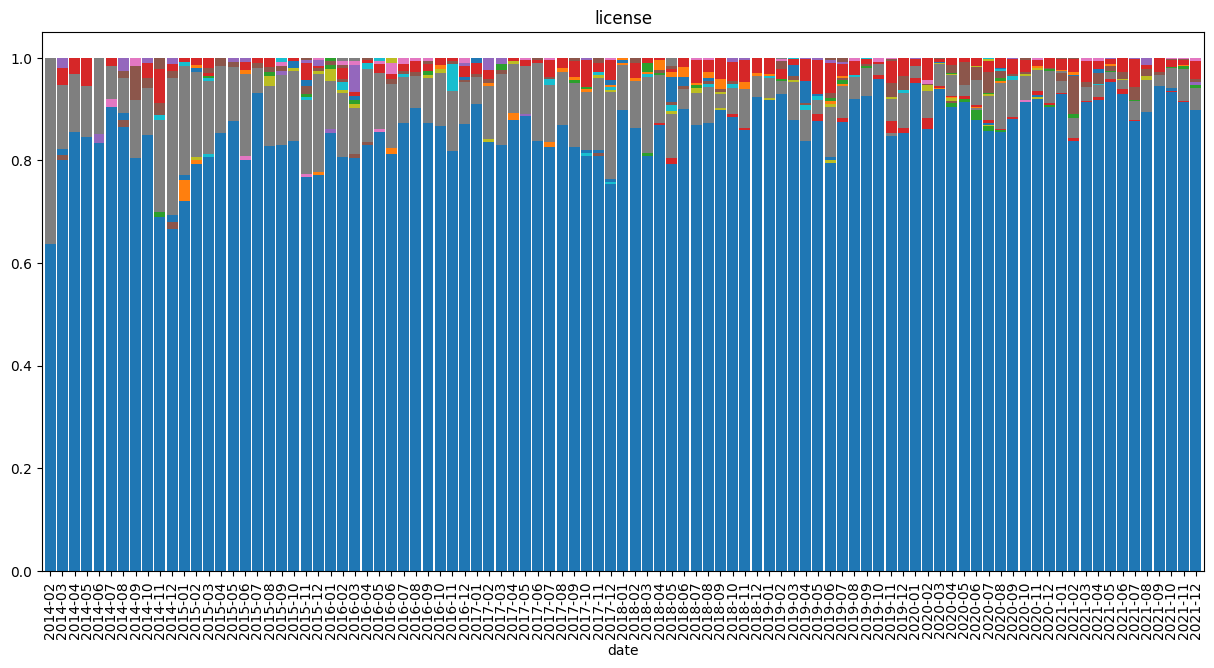

In [8]:
def plot_per_month(column, stretched=False, **kwargs):
    feature_df = df["date"].groupby([df["date"].dt.to_period("M"), df[column]]).count().unstack()
    if stretched:
        feature_df = feature_df.div(feature_df.sum(axis=1), axis=0)
    return feature_df.plot(kind="bar", stacked=True, figsize=(15,7), title=column, width=.9, **kwargs)
    
plot_per_month("license", True, legend=False)

<Axes: title={'center': 'published'}, xlabel='date'>

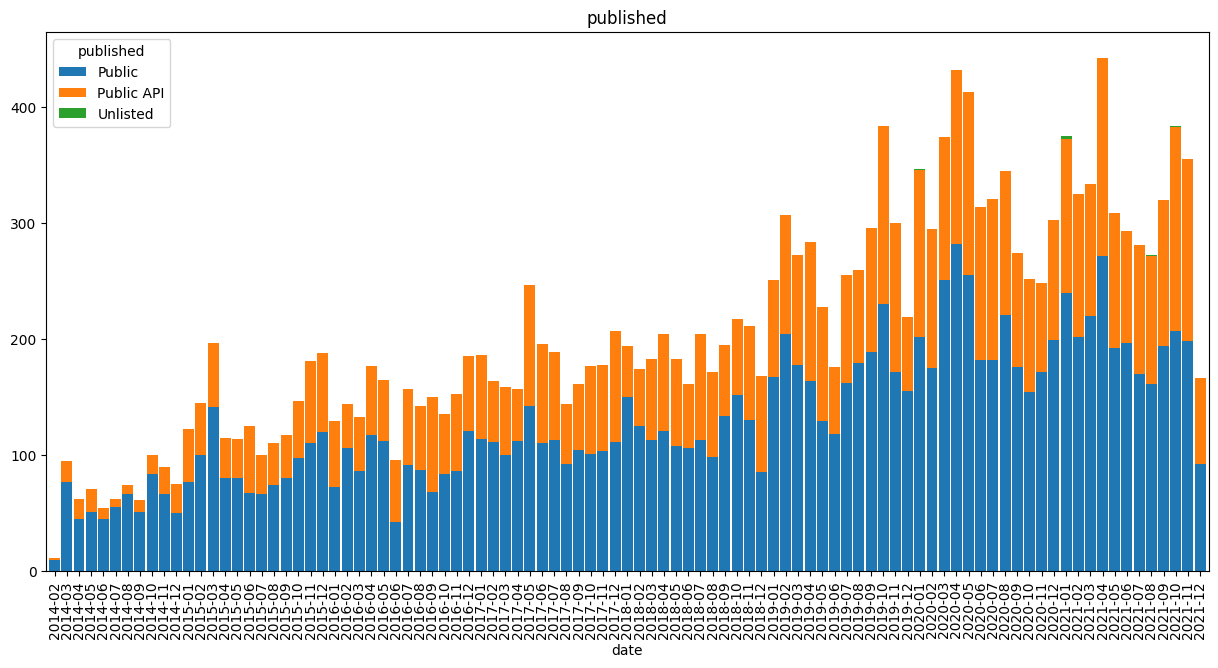

In [9]:
plot_per_month("published", False)

<Axes: title={'center': 'test'}, xlabel='date'>

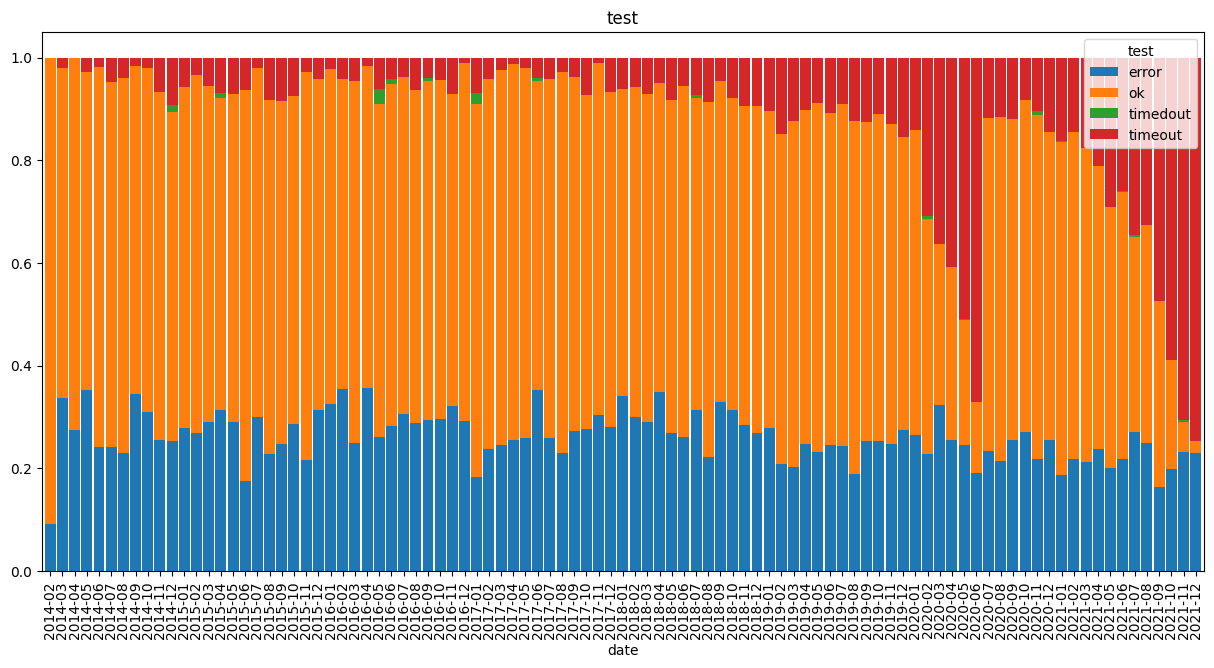

In [10]:
# currently in development, another filtering step.
plot_per_month("test", stretched=True, legend=True)

In [11]:
df["num_functions"] = df["functions"].apply(len)
df["num_functions"].describe()

count    19622.000000
mean         7.946234
std         10.261134
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        344.000000
Name: num_functions, dtype: float64

<Axes: title={'center': 'num_inputs'}, xlabel='date'>

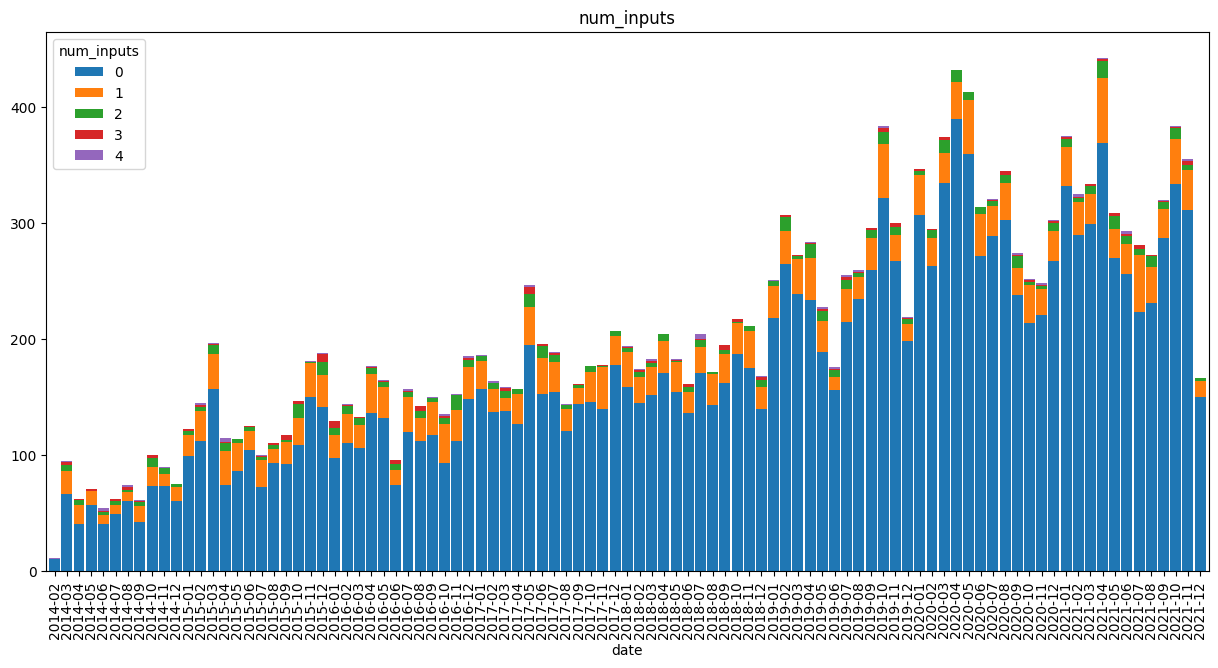

In [12]:
df["num_inputs"] = df["image_inputs"].apply(len)
plot_per_month("num_inputs", stretched=False, legend=True)

In [13]:
# these cases might be parsing failures? seem to always use macros inside functions or something.
# some use no functions but Main(){...} which seems to work in glsl but not viable for our dataset
from annotate import PARSER
print(PARSER.parse(bytes(df["image_code"][19616],encoding="utf-8")).root_node.has_error)
df.loc[df["num_functions"] == 0]

False


,id,name,author,description,tags,likes,viewed,published,date,time_retrieved,...,buffer_d_inputs,cube_a_code,cube_a_inputs,thumbnail,access,license,functions,test,num_functions,num_inputs
25,4s23Wc,pfhrector,pfhunk,80s vector graphics inspired kaliset,"[2d, fractal, kaliset]",7,791,Public,2014-03-11 02:44:55,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/4s23Wc...,shaders20k,CC-BY-NC-SA-3.0,[],ok,0,0
62,Md23DV,GLSL 2D Tutorials,vug,28 tutorials on writing pixel shaders at Shade...,[tutorial],581,48910,Public,2014-03-08 20:58:49,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/Md23DV...,shaders20k,CC-BY-NC-SA-3.0,[],error,0,3
424,XsSSRz,Tiny Ray Marcher 3.0,Aaro,Oh its on. I'm sure comment section will be fu...,"[reflection, ray, shadow, marching, tiny]",4,267,Public,2014-08-15 14:12:07,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/XsSSRz...,shaders20k,CC-BY-NC-SA-3.0,[],ok,0,0
565,Ms2XWw,Twist Scroller,ac3t1ne,Greetz!,"[2d, retro, amiga, ac3t1ne, scroller]",14,966,Public,2014-10-10 18:41:28,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/Ms2XWw...,shaders20k,CC-BY-NC-SA-3.0,[],ok,0,0
613,ld2SW3,A Pattern Emerges,okro,Takes a few seconds.,[dots],1,141,Public,2014-11-23 05:04:25,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/ld2SW3...,shaders20k,CC-BY-NC-SA-3.0,[],ok,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19362,Nty3Ry,Plotting by dmc3105,dmc3105,my first shader,[math],1,94,Public API,2021-11-26 15:06:50,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/Nty3Ry...,shaders20k,CC-BY-NC-SA-3.0,[],timeout,0,0
19422,std3zl,Lava Blob,Moustave,o,[yayyy],2,25,Public,2021-11-10 18:04:19,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/std3zl...,shaders20k,CC-BY-NC-SA-3.0,[],error,0,0
19479,7t3SDM,Tetragrammaton,4eckme,https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%...,[tetragrammaton],26,1891,Public,2021-12-11 07:59:44,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/7t3SDM...,shaders20k,CC-BY-NC-SA-3.0,[],timeout,0,0
19606,stKGDc,tiny voxels,flockaroo,...originally done in twigl.app (266 chars the...,"[voxel, golfing, tinycode]",21,305,Public API,2021-12-02 21:22:22,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/stKGDc...,shaders20k,cc-by-nc-sa-3.0,[],timeout,0,0


In [14]:
# TODO: refactor into a generator because I dislike the current shape. but figure out how batching and threadding works then?
# part of the filter.py or prepare.py script that will be done soon.
def split_functions(batch):
    # per function fields
    comments, headers, docstrings, bodies = [],[],[],[]
    # per document fields
    full_code, funcs, ids = [],[],[]
    for code, func_bytes, shader_id in zip(batch["image_code"], batch["functions"], batch["id"]):
        row_code = bytes(code,encoding="utf-8")
        for start_comment, start_header, end_header, end_docstring, end_function in func_bytes:
            comments.append(row_code[start_comment:start_header].decode(encoding="utf-8")),
            headers.append(row_code[start_header:end_header].decode(encoding="utf-8")),
            docstrings.append(row_code[end_header:end_docstring].decode(encoding="utf-8")),
            bodies.append(row_code[end_docstring:end_function].decode(encoding="utf-8")),
            full_code.append(row_code.decode(encoding="utf-8")),
            funcs.append((start_comment, start_header, end_header, end_docstring, end_function))
            ids.append(shader_id)
    return {
            "comment": comments,
            "header": headers,
            "docstring": docstrings,
            "body": bodies,
            "full_code": full_code,
            "func_bytes": funcs,
            "id": ids,
            }


# func_ds = ds.map(split_functions, batched=True, remove_columns=ds["train"].column_names) # full dataset to functions
func_ds = filtered_ds.map(split_functions, batched=True, remove_columns=filtered_ds.column_names) # only permissive shaders (the whole 20k set is single pass without common...)
if "train" in func_ds:
    func_ds = func_ds["train"]
func_ds

Map:   0%|          | 0/3425 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'comment', 'header', 'docstring', 'body', 'full_code', 'func_bytes'],
    num_rows: 16600
})

In [15]:
func_df = func_ds.to_pandas()
func_df.head() 

,id,comment,header,docstring,body,full_code,func_bytes
0,XsS3DV,,"vec2 center ( vec2 border , vec2 offset , vec2...",,\n\tvec2 c;\n\tif ( vel.x == 0.0 && vel.y == 0...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[49, 49, 103, 103, 506]"
1,XsS3DV,,"void circle ( float r , vec3 col , vec2 offset...",,\n\tvec2 pos = coord.xy / iResolution.y;\n\tfl...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[508, 508, 569, 569, 797]"
2,XsS3DV,,"vec3 band ( float shade, float low, float high...",,\n\n\tif ( (shade >= low) && (shade <= high) )...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[800, 800, 872, 872, 1067]"
3,XsS3DV,,vec3 gradient ( float shade ) {,,\n\tvec3 colour = vec3( (sin(iTime/2.0)*0.25)+...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[1069, 1069, 1100, 1100, 1876]"
4,XsS3DV,,"void mainImage( out vec4 fragColor, in vec2 fr...",,\n\n coord = fragCoord;\n \n\tcircle ( ....,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[1878, 1878, 1935, 1935, 2619]"


In [16]:
func_df["has_comment"] = func_df["comment"] != ""
func_df["has_docstring"] = func_df["docstring"] != ""
func_df["model_ctx"] = func_df["comment"] + func_df["header"] + func_df["comment"]
# how many functions are there, and what is the share of comments, 

xtab = pd.crosstab(func_df["has_comment"], func_df["has_docstring"], margins=True)
print(f"functions with context = {xtab.iloc[-1,-1] - xtab.iloc[0,0]}")
xtab

# for the permissive subset of shaders 21k the number goes down to like 253 for both... and 150 for valid shaders only.

functions with context = 3822


has_docstring,False,True,All
has_comment,,,
False,12778,1152,13930
True,2341,329,2670
All,15119,1481,16600


In [17]:
# FINDING: only about half the comments are unique.
# some frequent comment looks like a template maybe? should investigate
print(func_df["comment"].nunique())
func_df["comment"].value_counts(sort=True, ascending=False).head(10)

1941


comment
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                13930
//----------------------------------------------------------------------------------------\n//  3 out, 1 in...\n                                                                                                                                                                                                                                                                                                                                                                          

In [18]:
# FINDING = only about a third of function-headers are unique?
# it's expect to have one mainImage function per renderpass... but they are just whitesapce variable here - maybe we skip them in general
print(func_df["header"].nunique())
func_df["header"].value_counts(sort=True, ascending=False).head(10)

9110


header
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    1979
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      175
void mainImage(out vec4 fragColor, in vec2 fragCoord) {        136
void mainImage(out vec4 fragColor, in vec2 fragCoord)\n{       127
void mainImage( out vec4 fragColor, in vec2 fragCoord ){       100
float sdBox( vec3 p, vec3 b )\n{                                60
vec3 calcNormal( in vec3 pos )\n{                               47
void mainImage( out vec4 O, vec2 U )\n{                         45
void mainImage( out vec4 O, vec2 u )\n{                         41
float map(vec3 p)\n{                                            37
Name: count, dtype: int64

In [19]:
# looks like some are not exact or might even use the common pass to bypass this
func_df["header"].str.startswith("void mainImage").sum()

3224

In [20]:
# half the docstrings aren't unique?
# most common one is the shadertoy.com/new default for the main function
print(func_df["docstring"].nunique())
func_df["docstring"].value_counts(sort=True, ascending=False).head(10)

947


docstring
                                                             15119
\n    // Normalized pixel coordinates (from 0 to 1)            268
\n    // Based on gluLookAt man page                            19
\n    //from David Hoskin's "Hash without sine"                 12
\n\n    // Precompute values for skewed triangular grid         10
\n    // normalized pixel coordinates                            9
\n    \n    //numerator /= (abs(denominator)+1.0);               8
\n    // filter kernel                                           8
 // in [0,1]                                                     6
\n    \n    // Normalized pixel coordinates (from 0 to 1)        6
Name: count, dtype: int64

In [21]:
# indicator where the docstring is just something commented out - not helpful instructions.
func_df["docstring"].str.endswith(";").sum()

155

In [22]:
# the comment is just a link to some website/reference? although sometimes it's a bunch of natural langauge too?
print(func_df["comment"].str.contains("https://").sum())
print(func_df["comment"].str.contains("www.").sum())

352
365


In [23]:
# proposed model_ctx takes all of them in normal order (doens't filter out the naked functions)
print(func_df["model_ctx"].nunique())
func_df["model_ctx"].value_counts(sort=True, ascending=False).head(10)

9652


model_ctx
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    1932
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      170
void mainImage(out vec4 fragColor, in vec2 fragCoord) {        132
void mainImage(out vec4 fragColor, in vec2 fragCoord)\n{       126
void mainImage( out vec4 fragColor, in vec2 fragCoord ){        98
float sdBox( vec3 p, vec3 b )\n{                                57
void mainImage( out vec4 O, vec2 U )\n{                         44
void mainImage( out vec4 O, vec2 u )\n{                         41
vec3 calcNormal( in vec3 pos )\n{                               35
float map(vec3 p)\n{                                            35
Name: count, dtype: int64

In [24]:
# figure out if a function is needed, by removing if from body and check if the code still runs (you should have filtered for only working shaders before)

# step 1. subset the dataframe to only those rows that have comment and docstring
both_df = func_df[func_df["has_comment"] & func_df["has_docstring"]]
# 253 functions form 168 shaders, only 179 of which are unique combinations...
both_df["header"].value_counts(sort=True, ascending=False).head(10)

header
mat3 viewMatrix(vec3 eye, vec3 center, vec3 up) {                                  17
vec3 hash31(float p)\n{                                                            16
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{                         15
vec2 hash22(vec2 p) {                                                               8
float noise3D(vec3 p){                                                              5
float calcSoftshadow( in vec3 ro, in vec3 rd, in float mint, in float tmax )\n{     4
float checkersGradBox( in vec2 p )\n{                                               4
float F ( in vec2 coords )\n{                                                       3
void mainImage(out vec4 fragColor, in vec2 fragCoord){                              3
float snoise(vec2 v) {                                                              3
Name: count, dtype: int64

In [25]:
len(both_df)

329

In [26]:
# this step can timeout/hang -.-
# step 2. if code runs without the function.
from annotate import run_shader

def check_function_needed(row):
    code = row["full_code"]
    start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
    test_code = code[:start_comment] + code[end_function:] #TODO: this needs to be done in bytes -.-
    status = run_shader(test_code)
    return status == "error"


both_df["needed"] = both_df.apply(check_function_needed, axis=1)
both_df["needed"].value_counts()

C:\Users\Jan\AppData\Local\Temp\ipykernel_7308\4005513836.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_df["needed"] = both_df.apply(check_function_needed, axis=1)


needed
True     318
False     11
Name: count, dtype: int64

In [28]:
# down select the only the needed and working examples.
print(len(both_df))
both_df = both_df.loc[both_df["needed"]]
len(both_df)

329


318

In [29]:
from datasets import Dataset

both_df.loc[:,"input_both"] = both_df["comment"] + both_df["header"] + both_df["docstring"]
both_df.loc[:,"input_comment"] = both_df["comment"] + both_df["header"]
both_df.loc[:,"input_docstring"] = both_df["header"] + both_df["docstring"]
both_df.loc[:,"input_none"] = both_df["header"]
print(both_df.shape)
print(both_df["input_both"].nunique())
# remove the duplicates
both_df.drop_duplicates("input_both", inplace=True)
experiment_ds = Dataset.from_pandas(both_df)
experiment_ds

(318, 15)
257


C:\Users\Jan\AppData\Local\Temp\ipykernel_7308\1586844905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_df.loc[:,"input_both"] = both_df["comment"] + both_df["header"] + both_df["docstring"]
C:\Users\Jan\AppData\Local\Temp\ipykernel_7308\1586844905.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_df.loc[:,"input_comment"] = both_df["comment"] + both_df["header"]
C:\Users\Jan\AppData\Local\Temp\ipykernel_7308\1586844905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Dataset({
    features: ['id', 'comment', 'header', 'docstring', 'body', 'full_code', 'func_bytes', 'has_comment', 'has_docstring', 'model_ctx', 'needed', 'input_both', 'input_comment', 'input_docstring', 'input_none', '__index_level_0__'],
    num_rows: 257
})

In [30]:
# this pushes the dataset to the hub, uncomment with care!
# experiment_ds.push_to_hub("Vipitis/Shadereval-experiments-dev", private=False, commit_message="v0.2 filtered down to 257 examples, ensures working and Public+API")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Vipitis/Shadereval-experiments-dev/commit/d7775c097cec4a46812a3b35e1fff09a25bf8ecb', commit_message='v0.2 filtered down to 257 examples, ensures working and Public+API', commit_description='', oid='d7775c097cec4a46812a3b35e1fff09a25bf8ecb', pr_url=None, pr_revision=None, pr_num=None)